# Fast and Efficient Code Generation with BitBLAS Roller Component

Reimplemented and improved from **OSDI 22'Roller**: https://www.usenix.org/system/files/osdi22-zhu.pdf

Core Code: https://github.com/microsoft/BitBLAS/blob/main/bitblas/base/roller

Only takes seconds to optimize high performance kernels via hardware-aware white box search space recommendation.

<div style="text-align: center;">
    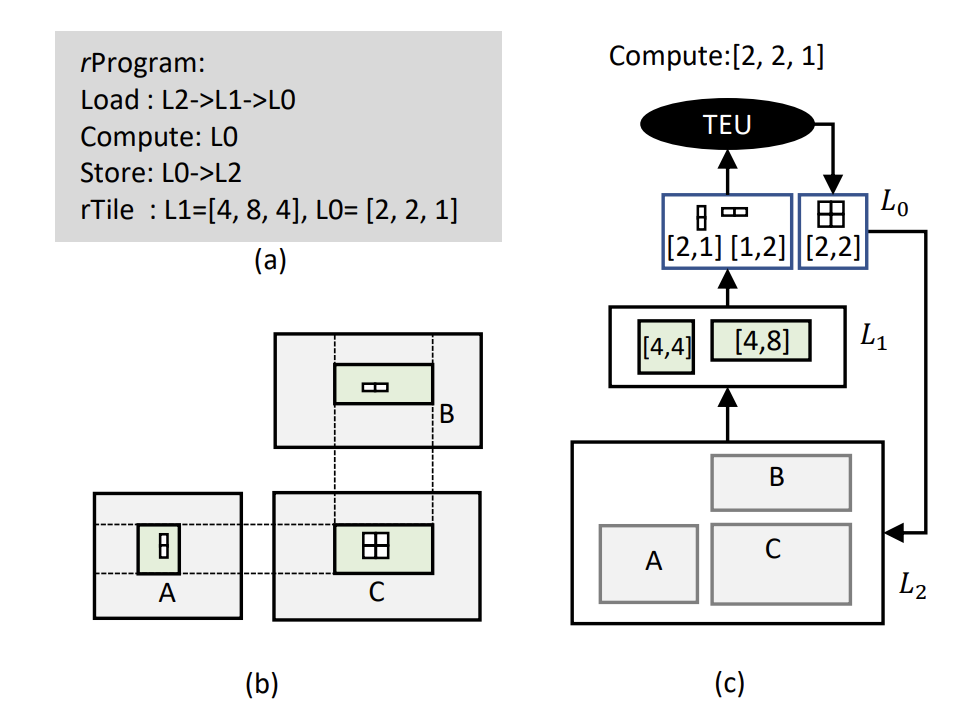
</div>


In [4]:
# Initialize Import
import bitblas
from bitblas import tvm as tvm

## 1. Get start with an elememt-wise add
tensor expression: B = A + 1.0

In [5]:
from tvm import te

A = te.placeholder((1024, 1024), name="A", dtype="float16")

def fcompute(i, j):
    return A[i, j] + 1.0

B = te.compute((1024, 1024), fcompute, name="B")

args = [A, B]
func = te.create_prim_func(args)

In [6]:
print(func) # TIR Script Function

# from tvm.script import tir as T

@T.prim_func
def main(A: T.Buffer((1024, 1024), "float16"), B: T.Buffer((1024, 1024), "float32")):
    T.func_attr({"tir.noalias": T.bool(True)})
    # with T.block("root"):
    for i, j in T.grid(1024, 1024):
        with T.block("B"):
            v_i, v_j = T.axis.remap("SS", [i, j])
            T.reads(A[v_i, v_j])
            T.writes(B[v_i, v_j])
            B[v_i, v_j] = T.Cast("float32", A[v_i, v_j]) + T.float32(1)


In [11]:
# import fast tunning related toolkits
from bitblas.base.roller.policy import DefaultPolicy
from bitblas.base.arch import CUDA
from bitblas.base.utils import apply_and_build

target = bitblas.auto_detect_nvidia_target()
print(f"{target=}")
arch = CUDA(target)

target='nvidia/geforce-rtx-4090'


### 2. Example Arch: CUDA
Codebase: https://github.com/microsoft/BitBLAS/blob/main/bitblas/base/arch/cuda.py

```python
class CUDA(TileDevice):

    def __init__(self, target: Union[Target, str]):
        if isinstance(target, str):
            target = tvm.target.Target(target)
        self.target = target
        self.sm_version = check_sm_version(self.target.arch)
        device = tvm.runtime.cuda(0)
        if not device.exist:
            raise RuntimeError("Cannot find cuda device 0.")
        self.device: tvm.runtime.Device = device
        self.platform: str = "CUDA"
        self.smem_cap = device.max_shared_memory_per_block
        self.compute_max_core = device.multi_processor_count
        self.warp_size = device.warp_size
        self.compute_capability = device.compute_version.replace(".", "")
        self.reg_cap: int = 65536
        self.max_smem_usage: int = 2 * self.smem_cap
        self.sm_partition: int = 4
        self.l2_cache_size_bytes: int = target.l2_cache_size_bytes
        # the number of transaction size in bytes
        self.transaction_size: List[int] = [32, 128]  # in bytes
        # bandwidth in MB/s, will be used for recommend basic tile size
        # TODO(lei): find some way to get the real bandwidth
        # However, the ratio of bandwidth between different devices can
        # be similar. The bandwidth can work for another devices as well.
        self.bandwidth: List[int] = [750, 12080]
        # get the available tensor instructions during runtime to avoid
        # the dependency of the tensor intrinsics registration
        self.available_tensor_instructions: List[TensorInstruction] = None

    def get_avaliable_tensorintrin_shapes(self):
        from tvm.tir.tensor_intrin.cuda import get_wmma_intrin_group, get_mma_intrin_group

        self.available_tensor_instructions = (
            TensorInstruction("mma", get_mma_intrin_group, [16, 16]),
            TensorInstruction("wmma", get_wmma_intrin_group, [16, 16]),
        )
        return [t.shape for t in self.available_tensor_instructions]

    def __repr__(self):
        return f"CUDA({self.target})"
```

In [22]:
policy = DefaultPolicy(func=func, arch=arch)
configs = policy.emit_config(topk=20)

for config in configs:
    print(config)

{'block': [128, 128], 'thread': [16, 8], 'rstep': [64], 'step': [1, 2], 'vectorize': {'A': 8, 'B': 8}}
{'block': [64, 128], 'thread': [8, 16], 'rstep': [64], 'step': [1, 2], 'vectorize': {'A': 8, 'B': 8}}
{'block': [128, 64], 'thread': [16, 8], 'rstep': [64], 'step': [1, 2], 'vectorize': {'A': 8, 'B': 8}}
{'block': [128, 256], 'thread': [8, 16], 'rstep': [64], 'step': [1, 2], 'vectorize': {'A': 8, 'B': 8}}
{'block': [256, 128], 'thread': [16, 8], 'rstep': [64], 'step': [1, 2], 'vectorize': {'A': 8, 'B': 8}}
{'block': [64, 64], 'thread': [16, 8], 'rstep': [64], 'step': [1, 2], 'vectorize': {'A': 8, 'B': 8}}
{'block': [32, 128], 'thread': [8, 16], 'rstep': [64], 'step': [1, 2], 'vectorize': {'A': 8, 'B': 8}}
{'block': [128, 32], 'thread': [16, 8], 'rstep': [64], 'step': [1, 2], 'vectorize': {'A': 8, 'B': 8}}
{'block': [64, 256], 'thread': [8, 16], 'rstep': [64], 'step': [1, 2], 'vectorize': {'A': 8, 'B': 8}}
{'block': [256, 64], 'thread': [16, 8], 'rstep': [64], 'step': [1, 2], 'vectoriz

In [7]:
bitblas.set_log_level("Debug")

In [8]:
cpresults, best = apply_and_build(func, configs, arch, parallel_build=True)

2024-10-24 12:57:34 [BitBLAS:DEBUG]: Apply config {'block': [2, 1024], 'thread': [2, 64], 'rstep': []}
2024-10-24 12:57:34 [BitBLAS:DEBUG]: Apply config {'block': [4, 512], 'thread': [4, 32], 'rstep': []}
2024-10-24 12:57:34 [BitBLAS:DEBUG]: Apply config {'block': [8, 256], 'thread': [8, 16], 'rstep': []}
2024-10-24 12:57:34 [BitBLAS:DEBUG]: Apply config {'block': [16, 128], 'thread': [16, 8], 'rstep': []}
2024-10-24 12:57:34 [BitBLAS:DEBUG]: Apply config {'block': [32, 64], 'thread': [16, 8], 'rstep': []}
2024-10-24 12:57:34 [BitBLAS:DEBUG]: Apply config {'block': [1, 1024], 'thread': [1, 128], 'rstep': []}
2024-10-24 12:57:34 [BitBLAS:DEBUG]: Apply config {'block': [2, 512], 'thread': [2, 64], 'rstep': []}
2024-10-24 12:57:34 [BitBLAS:DEBUG]: Apply config {'block': [4, 256], 'thread': [4, 32], 'rstep': []}
2024-10-24 12:57:34 [BitBLAS:DEBUG]: Apply config {'block': [8, 128], 'thread': [8, 16], 'rstep': []}
2024-10-24 12:57:34 [BitBLAS:DEBUG]: Apply config {'block': [16, 64], 'thread'

In [9]:
# get the scheduled ir
print(best.sch.mod)

# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer((1024, 1024), "float16"), B: T.Buffer((1024, 1024), "float32")):
        T.func_attr({"tir.noalias": T.bool(True)})
        # with T.block("root"):
        for ax0_0_ax1_0_fused in T.thread_binding(2048, thread="blockIdx.x"):
            for ax1_1_0 in T.thread_binding(4, thread="vthread.x"):
                for ax0_1_0 in T.thread_binding(1, thread="vthread.y"):
                    for ax0_1_1_0_ax1_1_1_0_fused in T.thread_binding(128, thread="threadIdx.x"):
                        for ax0_1_1_1, ax1_1_1_1 in T.grid(1, 1):
                            with T.block("B"):
                                v0 = T.axis.spatial(1024, ax0_0_ax1_0_fused // 2 + ax0_1_0 + ax0_1_1_1)
                                v1 = T.axis.spatial(1024, ax0_0_ax1_0_fused % 2 * 512 + ax1_1_0 * 128 + ax0_1_1_0_ax1_1_1_0_fused + ax1_1_1_1)
                                T.reads

In [10]:
# get generated cuda source
print(best.code)

#if defined(__CUDA_ARCH__) && (__CUDA_ARCH__ < 530)

typedef unsigned short uint16_t;
typedef unsigned char uint8_t;
typedef signed char int8_t;
typedef int int32_t;
typedef unsigned long long uint64_t;
typedef unsigned int uint32_t;

#define TVM_FORCE_INLINE inline __attribute__((always_inline))
#define TVM_XINLINE TVM_FORCE_INLINE __device__ __host__
#define TVM_ALIGNED(x) __attribute__ ((aligned(x)))
#define TVM_HALF_OPERATOR(RTYPE, OP)                              \
  TVM_XINLINE RTYPE operator OP (half a, half b) {                \
    return RTYPE(float(a) OP float(b));                           \
  }                                                               \
  template<typename T>                                            \
  TVM_XINLINE RTYPE operator OP (half a, T b) {                   \
    return RTYPE(float(a) OP float(b));                           \
  }                                                               \
  template<typename T>                           

## 2. Gemm tuning with Tensor Core 
Tensor Expression: $C[m, n] = A[m, k] * B[n, k]$

In [12]:
M = N = K = 16384
# Describe the matrix multiplication in TE
A = te.placeholder((M, K), name="A", dtype="float16")
B = te.placeholder((N, K), name="B", dtype="float16")

k = te.reduce_axis((0, K), name="k")
C = te.compute(
    (M, N),
    lambda i, j: te.sum(A[i, k].astype("float16") * B[j, k].astype("float16"), axis=k),
    name="C",
)
args = [A, B, C]
func = te.create_prim_func(args)
print(func)

# from tvm.script import tir as T

@T.prim_func
def main(A: T.Buffer((16384, 16384), "float16"), B: T.Buffer((16384, 16384), "float16"), C: T.Buffer((16384, 16384), "float16")):
    T.func_attr({"tir.noalias": T.bool(True)})
    # with T.block("root"):
    for i, j, k in T.grid(16384, 16384, 16384):
        with T.block("C"):
            v_i, v_j, v_k = T.axis.remap("SSR", [i, j, k])
            T.reads(A[v_i, v_k], B[v_j, v_k])
            T.writes(C[v_i, v_j])
            with T.init():
                C[v_i, v_j] = T.float16(0)
            C[v_i, v_j] = C[v_i, v_j] + A[v_i, v_k] * B[v_j, v_k]


In [13]:
from bitblas.base.roller.policy import TensorCorePolicy
from bitblas.gpu.matmul_analysis import get_tensorized_func_and_tags

In [14]:
tensorized_func, tags = get_tensorized_func_and_tags(func, arch.target)
policy = TensorCorePolicy(func=tensorized_func, arch=arch, tags=tags)
configs = policy.emit_config(topk=20)

for config in configs:
    print(config)

{'block': [128, 128], 'warp': [64, 64], 'rstep': [32], 'use_tc': True, 'vectorize': {'A_reindex': 8, 'B_reindex': 8}}
{'block': [64, 256], 'warp': [32, 128], 'rstep': [32], 'use_tc': True, 'vectorize': {'A_reindex': 8, 'B_reindex': 8}}
{'block': [256, 64], 'warp': [128, 32], 'rstep': [32], 'use_tc': True, 'vectorize': {'A_reindex': 8, 'B_reindex': 8}}
{'block': [64, 128], 'warp': [32, 64], 'rstep': [32], 'use_tc': True, 'vectorize': {'A_reindex': 8, 'B_reindex': 8}}
{'block': [128, 64], 'warp': [64, 32], 'rstep': [32], 'use_tc': True, 'vectorize': {'A_reindex': 8, 'B_reindex': 8}}
{'block': [128, 256], 'warp': [64, 128], 'rstep': [32], 'use_tc': True, 'vectorize': {'A_reindex': 8, 'B_reindex': 8}}
{'block': [256, 128], 'warp': [128, 64], 'rstep': [32], 'use_tc': True, 'vectorize': {'A_reindex': 8, 'B_reindex': 8}}
{'block': [64, 64], 'warp': [32, 32], 'rstep': [32], 'use_tc': True, 'vectorize': {'A_reindex': 8, 'B_reindex': 8}}
{'block': [256, 256], 'warp': [128, 128], 'rstep': [32], '

In [19]:
cpresults, best = apply_and_build(func, configs, arch, parallel_build=True)

2024-10-24 13:31:32 [BitBLAS:DEBUG]: Apply config {'block': [128, 128], 'warp': [64, 64], 'rstep': [32], 'use_tc': True, 'vectorize': {'A_reindex': 8, 'B_reindex': 8}}
2024-10-24 13:31:32 [BitBLAS:DEBUG]: Apply config {'block': [64, 256], 'warp': [32, 128], 'rstep': [32], 'use_tc': True, 'vectorize': {'A_reindex': 8, 'B_reindex': 8}}
2024-10-24 13:31:32 [BitBLAS:DEBUG]: Apply config {'block': [256, 64], 'warp': [128, 32], 'rstep': [32], 'use_tc': True, 'vectorize': {'A_reindex': 8, 'B_reindex': 8}}
2024-10-24 13:31:32 [BitBLAS:DEBUG]: Apply config {'block': [64, 128], 'warp': [32, 64], 'rstep': [32], 'use_tc': True, 'vectorize': {'A_reindex': 8, 'B_reindex': 8}}
2024-10-24 13:31:32 [BitBLAS:DEBUG]: Apply config {'block': [128, 64], 'warp': [64, 32], 'rstep': [32], 'use_tc': True, 'vectorize': {'A_reindex': 8, 'B_reindex': 8}}
2024-10-24 13:31:32 [BitBLAS:DEBUG]: Apply config {'block': [128, 256], 'warp': [64, 128], 'rstep': [32], 'use_tc': True, 'vectorize': {'A_reindex': 8, 'B_reindex

In [20]:
# get generated cuda source
print(best.code)


__device__ __inline__ dim3 rasterization2DColumn(const int panel_width) {
    const auto baseBlockIdx = blockIdx.x + gridDim.x *blockIdx.y;
    const auto totalPanel = (gridDim.x * gridDim.y +panel_width * gridDim.x - 1) / (panel_width * gridDim.x);
    const auto totalBlock = gridDim.x * gridDim.y;
    const auto panelIdx = baseBlockIdx / (panel_width *gridDim.x);
    const auto strideLd = panelIdx + 1 < totalPanel ?panel_width : (totalBlock - panelIdx * (panel_width *gridDim.x)) / gridDim.x;
    const auto bx = (panelIdx & 1) ? gridDim.x -(baseBlockIdx - panelIdx * panel_width * gridDim.x) /strideLd - 1 : (baseBlockIdx - panelIdx * panel_width *gridDim.x) / strideLd;
    const auto by = (baseBlockIdx - panelIdx * panel_width *gridDim.x) % strideLd + panelIdx * panel_width;
    const auto bz = blockIdx.z;
    
    dim3 blockIdx(bx, by, bz);
    return blockIdx;
}
    #if defined(__CUDA_ARCH__) && (__CUDA_ARCH__ < 530)

typedef unsigned short uint16_t;
typedef unsigned char uint8_t;
t